This notebook will develope tools to calculate the pressure from the hydrostatic relation. 

In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

from salishsea_tools import viz_tools, psu_tools, grid_tools

import gsw

%matplotlib inline

Plan: 
* Use hydrostatic approximation to calculate pressure:
$ \frac{\partial p}{\partial z} = -\rho g $ 
with $p(z=0) = 0$
* For now, calculate density with the function Susan gave me. How should this change with TEOS-10?
* To enforce $p(z=0)=0$, remove $\rho(z_0)*g*z_0$

# Loading

In [2]:
mesh_mask = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')
grid = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

bathy = grid.variables['Bathymetry'][:]
# Sample file for testing calculations
fT = nc.Dataset('/results/SalishSea/nowcast/01apr15/SalishSea_1h_20150401_20150401_grid_T.nc')

In [3]:
tmask = mesh_mask.variables['tmask'][:]
e3t_0 = mesh_mask.variables['e3t'][:]
gdept_0 = mesh_mask.variables['gdept'][:]
gdepw_0 = mesh_mask.variables['gdepw'][:]
mbathy = mesh_mask.variables['mbathy'][0,:,:]

In [4]:
ssh = fT.variables['sossheig'][:]
sal = fT.variables['vosaline'][:]
temp = fT.variables['votemper'][:]
rho = psu_tools.calculate_density(temp, sal)

In [5]:
input_vars = {'e3t_0': e3t_0,
              'gdept_0': gdept_0,
              'gdepw_0': gdepw_0}
grids = grid_tools.calculate_time_dependent_grid(e3t_0[0,...], tmask[0,...], ssh, input_vars)

In [6]:
def calculate_pressure(rho, e3t_t, gdept_t, tmask):
    """Integrate density to calulate pressure.
    Use time-dependent scale factors
    
    returns pressure in Pascals"""
    g = 9.81 # is there a constant module that I an grab this from?
    
    # integrate density to get pressure
    p = np.cumsum(g*rho*e3t_t*tmask, axis=1)
    p = p - np.expand_dims(g*rho[:,0,...]*gdept_t[:,0,...], axis=1) # Attempt to approximate p(z=0)=0.
    
    return p
    

In [7]:
t=2
p_t = calculate_pressure(rho[0:t], grids['e3t_t'][0:t], grids['gdept_t'][0:t], tmask)

In [8]:
p_t[0,:,400,300]

array([   5005.81155713,   15049.53470838,   25162.81285411,
         35317.73250337,   45494.21754862,   55682.59381723,
         65878.10702516,   76078.91558965,   86286.01109721,
         96502.77311311,  106736.42776031,  117001.53608691,
        127327.02385427,  137769.85915752,  148441.02538412,
        159555.68815659,  171529.15031585,  185159.45691969,
        201958.08468826,  224711.49714982,  232411.59515234,
        232411.59515234,  232411.59515234,  232411.59515234,
        232411.59515234,  232411.59515234,  232411.59515234,
        232411.59515234,  232411.59515234,  232411.59515234,
        232411.59515234,  232411.59515234,  232411.59515234,
        232411.59515234,  232411.59515234,  232411.59515234,
        232411.59515234,  232411.59515234,  232411.59515234,
        232411.59515234])

# Compare with pressure from gsw

In [9]:
lat = fT.variables['nav_lon'][:]
p_gsw = gsw.p_from_z(-grids['gdept_t'][0:t], lat)
p_gsw[0,:,400,300]

array([   0.51327821,    1.53984072,    2.56641405,    3.5930035 ,
          4.61961961,    5.64628195,    6.67303117,    7.69994263,
          8.72716712,    9.7549964 ,   10.78399686,   11.81527485,
         12.85098138,   13.89530694,   14.95639751,   16.05007422,
         17.20697692,   18.48613582,   20.00008528,   21.95914955,
         23.56480451,   24.33956646,   35.60989799,   45.7049393 ,
         60.04610502,   78.6342806 ,  100.69156321,  125.1405956 ,
        151.05066233,  177.78806145,  204.97440285,  232.39935042,
        259.95032418,  287.56825157,  315.22250208,  342.89722454,
        370.58423274,  398.27938518,  425.9804845 ,  453.68643104])

In [10]:
diff = (p_t*10**(-4) - p_gsw)*tmask

In [11]:
diff[0,:,400,300]

array([-0.01269705, -0.03488725, -0.05013276, -0.06123025, -0.07019785,
       -0.07802257, -0.08522046, -0.09205107, -0.09856601, -0.10471909,
       -0.11035409, -0.11512124, -0.118279  , -0.11832103, -0.11229497,
       -0.0945054 , -0.05406189,  0.02980988,  0.19572319,  0.51200017,
       -0.323645  , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ])

# Internal Tide pressure

$ P_{internal tide} = P_{hydrostatic} - P_{depth averaged}$

In [12]:
def depth_average(p, e3t, tmask):
    H = np.sum(e3t*tmask,axis=1)
    p_integral = np.sum(p*e3t*tmask,axis=1)
    
    p_davg = p_integral/H
    p_davg = np.nan_to_num(p_davg)
    
    return p_davg

In [13]:
p_davg = depth_average(p_t, grids['e3t_t'][0:t], tmask )

/home/nsoontie/anaconda3/envs/analysis/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide


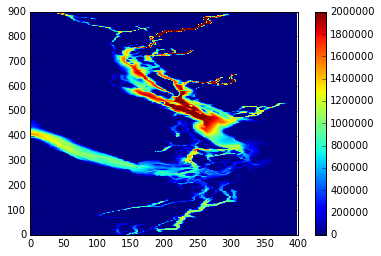

In [14]:
plt.pcolormesh(p_davg[0,...],vmin=0,vmax=2*10**6)
plt.colorbar()

In [15]:
p_internal = p_t - np.expand_dims(p_davg,axis=1)
p_internal = np.ma.array(p_internal, mask = np.ones(p_internal.shape) - tmask)

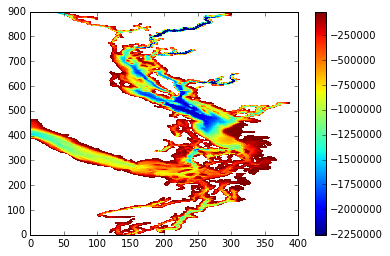

In [16]:
plt.pcolormesh(p_internal[0,0,...])
plt.colorbar()

(400, 0)

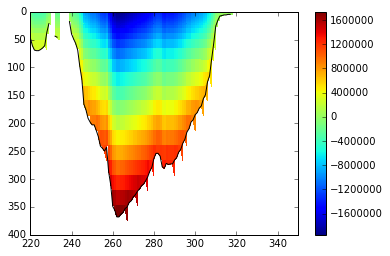

In [17]:
j=450
yy,_ = np.meshgrid(np.arange(p_internal.shape[-1]),np.arange(p_internal.shape[1]))
plt.pcolormesh(yy, grids['gdepw_t'][0,:,j,:]-ssh[0,j,:],p_internal[0,:,j,:])
plt.plot(np.arange(bathy[j,:].shape[-1]),bathy[j,:],'-k',label='bathymetry')
plt.colorbar()
plt.xlim([220,350])
plt.ylim([400,00])

Weird juts below the bathymetry. Investigate:

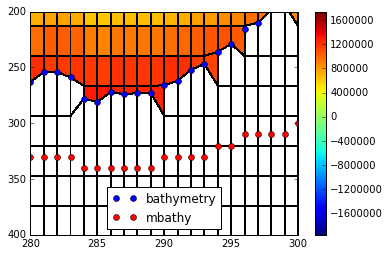

In [18]:
j=450
yy,_ = np.meshgrid(np.arange(p_internal.shape[-1]),np.arange(p_internal.shape[1]))
plt.pcolormesh(yy, grids['gdepw_t'][0,:,j,:]-ssh[0,j,:],p_internal[0,:,j,:],edgecolors='k')
plt.plot(np.arange(bathy[j,:].shape[-1]),bathy[j,:],'ob',label='bathymetry')
plt.plot(np.arange(mbathy[j,:].shape[-1]),10*mbathy[j,:],'or',label='mbathy')
plt.colorbar()
plt.xlim([280,300])
plt.ylim([400,200])
plt.legend(loc=8)

Juts are a result of how pcolormesh shades each cell and how mbathy is changing... So it is just an artifact of plotting. My suggestion is to plot the land over top if it is a real bother.

In [19]:
mbathy = mesh_mask.variables['mbathy'][0,:,:]
bottom_0 = np.zeros(mbathy.shape)
bottom_t = np.zeros(gdept_0[0,0,...].shape)
for i in np.arange(mbathy.shape[1]):
    for j in np.arange(mbathy.shape[0]):
        level = mbathy[j,i]
        bottom_0[j,i] = gdepw_0[0,level,j,i]
        bottom_t[j,i] =grids['gdepw_t'][0,level,j,i]



(200, 350)

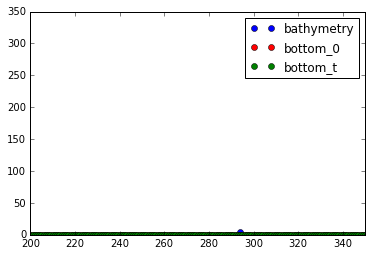

In [20]:
plt.plot(np.arange(bathy[j,:].shape[-1]),bathy[j,:],'ob',label='bathymetry')
plt.plot(np.arange(bathy[j,:].shape[-1]),bottom_0[j,:],'or',label='bottom_0')
plt.plot(np.arange(bathy[j,:].shape[-1]),bottom_t[j,:],'og',label='bottom_t')
plt.legend()
plt.xlim([200,350])